First lets import some important packages such as numpy, viresclient, and asilib which wraps the trex/themis/and rego image loaders

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import asilib
import asilib.asi

from viresclient import set_token
from viresclient import SwarmRequest

from EB import EBplotsNEC #Imports E and B data and backend of GUI

import datetime

c:\Users\1101w\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


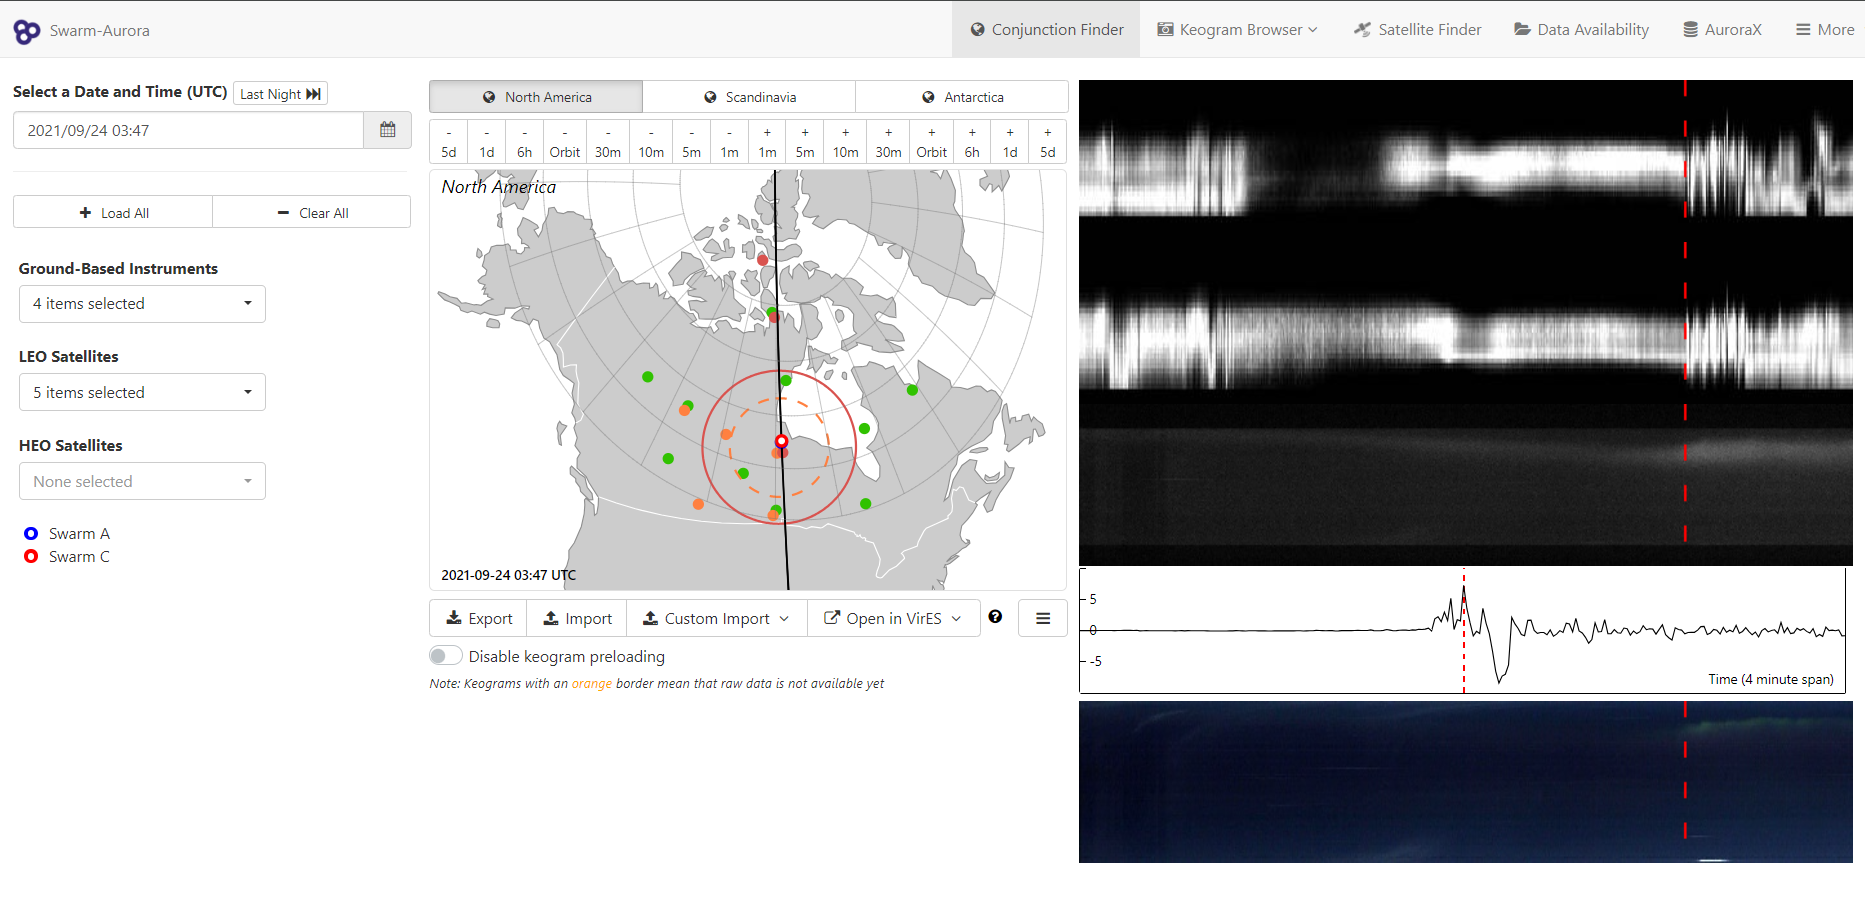

Now lets get the E and B data for this event using my own program

In [2]:
daterange=(datetime.datetime(2021, 9, 24, 3, 46), datetime.datetime(2021, 9, 24, 3, 48))
dict={'time_range': daterange,
       'satellite_graph': ['swarma', 'swarmc'], 'coordinate_system': ['North East Centre'], 'graph_B_chosen': ['East'],
         'B_frequency': ['50Hz'], 'E_frequency': ['16Hz'], 'graph_E_chosen': ['North'], 'graph_PF_chosen': None, 'FAC': False,
           'Difference': False, 'E_B_ratio': None, 'Pixel_intensity': False, 'sky_map_values': None, 'bandpass': [False], 'heatmap': None, #All False from here, these are for further functionaility 
             'conductivities': None, 'animation': False, 'Time_Series': None, 'E_periodogram': None, 'B_periodogram': None, 'EB_periodogram': None,
               'sampling_rate': None, 'window_length': None, 'EB_cross power': None, 'EB_cross phase': None, 'lags_cross': None, 'nperseg': None,
                 'lag': False, 'time_range_single':None,
                   'singles_graph': None, 'pixel_average': None, "E_difference":None, "B_difference": None, "PF_difference": None}

Token saved for https://vires.services/ows
{'time_range': (datetime.datetime(2021, 9, 24, 3, 46), datetime.datetime(2021, 9, 24, 3, 48)), 'satellite_graph': ['swarma', 'swarmc'], 'coordinate_system': ['North East Centre'], 'graph_B_chosen': ['East'], 'B_frequency': ['50Hz'], 'E_frequency': ['16Hz'], 'graph_E_chosen': ['North'], 'graph_PF_chosen': None, 'FAC': False, 'Difference': False, 'E_B_ratio': None, 'Pixel_intensity': False, 'sky_map_values': None, 'bandpass': [False], 'heatmap': None, 'conductivities': None, 'animation': False, 'Time_Series': None, 'E_periodogram': None, 'B_periodogram': None, 'EB_periodogram': None, 'sampling_rate': None, 'window_length': None, 'EB_cross power': None, 'EB_cross phase': None, 'lags_cross': None, 'nperseg': None, 'lag': False, 'time_range_single': None, 'singles_graph': None, 'pixel_average': None, 'E_difference': None, 'B_difference': None, 'PF_difference': None}
dict_keys(['time_range', 'satellite_graph', 'coordinate_system', 'graph_B_chosen', 

<ipython-input-3-509613c1bd7b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


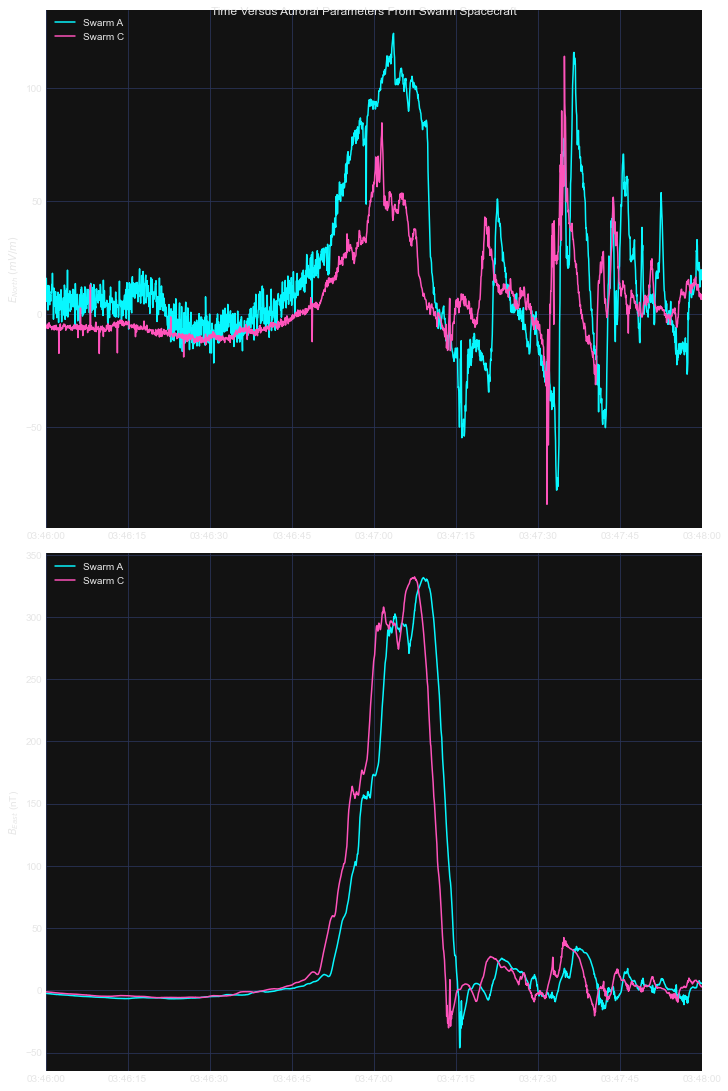

In [3]:
fig,axes,data = EBplotsNEC(dict)
fig.show()

Good we can see a nice  upward field aligned current $dB = +$ at 3:47:12


Lets now dig into the imaging and some of the data

20210924_034600_034800_trex_rgb_gill_fisheye.mp4: |###################  | 95%
Animation saved to C:\Users\1101w\asilib-data\animations\20210924_034600_034800_trex_rgb_gill_fisheye.mp4


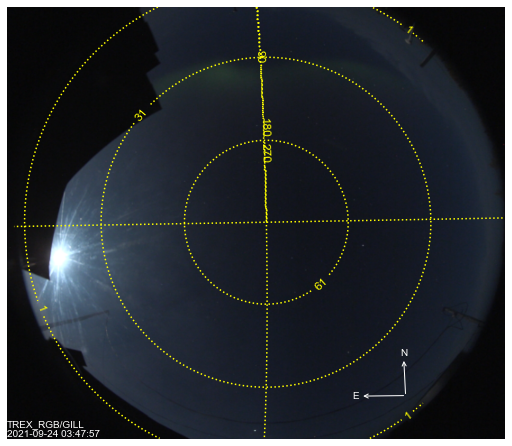

In [27]:
fig, ax = plt.subplots(
    1, 1, figsize=(7, 10), constrained_layout=True
)
asi = asilib.asi.trex_rgb('gill', time_range=daterange, alt=110)
gen = asi.animate_fisheye(
    ax=ax, azel_contours=True, overwrite=True, cardinal_directions='NE', color_bounds=[20,30], color_brighten=False,
)
from IPython.display import Video
Video(r"C:\Users\1101w\asilib-data\animations\20210924_034600_034800_trex_rgb_gill_fisheye.mp4")

In [28]:

from IPython.display import Video

Video(r"C:\Users\1101w\asilib-data\animations\20210924_034600_034800_rego_gill_fisheye.mp4", embed=True)

Now we want to check the mapping quality! Ideally, for the redline emission we want to line up the $dB$ to the pixel intensity peak so we should first guess 190km and refine from there. This uses two offical skymaps and interpolates between the two, below is the implementation in asilib.

In [29]:
_skymap=asi.skymap
interp_lat = utils.calculate_slope(_skymap['FULL_MAP_LATITUDE'][0, :, :], _skymap['FULL_MAP_LATITUDE'][1, :, :], _skymap['FULL_MAP_ALTITUDE'] / 1000, _skymap['FULL_MAP_ALTITUDE'] / 1000)  #Get the skymap then interp both
interp_lon = utils.calculate_slope(_skymap['FULL_MAP_LONGITUDE'][0, :, :], _skymap['FULL_MAP_LONGITUDE'][1, :, :], _skymap['FULL_MAP_ALTITUDE'] / 1000 , _skymap['FULL_MAP_ALTITUDE'] / 1000)  #Get the skymap then interp both
lat = utils.interpolate_matrix(_skymap['FULL_MAP_LATITUDE'][0, :, :], interp_lat,  _skymap['FULL_MAP_ALTITUDE'] / 1000, alt)
lon = utils.interpolate_matrix(_skymap['FULL_MAP_LONGITUDE'][0, :, :], interp_lon,  _skymap['FULL_MAP_ALTITUDE'] / 1000, alt)


NameError: name 'utils' is not defined

Additionally, asilib has borrows a function from a different ASI (TODO)
```
from typing import Tuple

import numpy as np

import pymap3d


Re = 6378.14  # km

def geodetic_skymap(
        imager_lla:Tuple[float],
        az_skymap:np.ndarray, 
        el_skymap:np.ndarray, 
        alt:float
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Project each pixel's (az, el) coordinates to geodetic (lat, lon) coordinates at an emission
    altitude using a spherical earth model.

    Parameters
    ----------
    imager_lla:tuple
        The imager's latitude, longitude, and altitude in km.
    az_skymap:np.ndarray 
        A 2d array of pixel azimuths. 
    el_skymap:np.ndarray 
        A 2d array of pixel elevations.
    alt:float
        Auroral emission altitude in km to map to.

    Returns
    -------
    np.ndarray
        The latitude skymap.
    np.ndarray
        The longitude skymap.
    """
    lat_skymap = np.zeros_like(az_skymap)
    lon_skymap = np.zeros_like(az_skymap)
    _alts = np.zeros_like(az_skymap)

    el_skymap[el_skymap <= 0] = np.nan

    # Range from observer to target assuming Earth is spherical, i.e. not an ellipsoid.
    # https://github.com/space-physics/dascasi/blob/4d72aa91e471a495566044c3fc387344dd12461f/src/dascasi/io.py#L107C32-L107C32
    _el_rad = np.deg2rad(el_skymap)
    _range = np.sqrt(
        (Re+alt)**2 +
        (Re+imager_lla[-1])**2 - 
        2*(Re+alt)*(Re+imager_lla[-1])*np.sin(
            _el_rad + np.arcsin((Re+imager_lla[-1])/(Re+alt)*np.cos(_el_rad))
            )
        )

    for row in range(az_skymap.shape[0]):
        for col in range(az_skymap.shape[1]):
            # Based on Michael Hirsh's (scivision) dascasi package.
            lat_skymap[row, col], lon_skymap[row, col], _alts[row, col] = pymap3d.aer2geodetic(
                az_skymap[row, col],
                el_skymap[row, col],
                _range[row, col] * 1e3,
                *imager_lla[:2], 
                1E3*imager_lla[-1],
                deg=True,
            )
    return lat_skymap, lon_skymap

```

For this date, given an altitude of 190km for a rego image, these are the two images produced where the x is latitude, y is longitude and the color is difference in latitude #Maybe do quadratures?. Differences are most apparent in the edges.

Now doing the same comparison for the TREX rgb imager for this datetime we get.

Now doing the same comparison with 5 other dates.
```
def test_geodetic_skymap():
    """
    Compare the (lat, lon) skymaps between the asilib and the official implementation.
    """
    time = '2020-01-01'
    ref_asi = asilib.asi.themis('GILL', time=time, load_images=False, alt=110)
    asi = asilib.asi.themis('GILL', time=time, load_images=False, custom_alt=True, alt=110)

    fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(4, 8))
    ref_asi._pcolormesh_nan(
        ref_asi.skymap['lon'], ref_asi.skymap['lat'], ref_asi.skymap['lat'], ax[0]
        )
    asi._pcolormesh_nan(asi.skymap['lon'], asi.skymap['lat'], asi.skymap['lat'], ax[1])
    return
```

<video controls src="C:\Users\1101w\asilib-data\animations\20210924_034600_034800_trex_rgb_gill_fisheye.mp4" >